In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linalg
from cmath import *
from math import *
import numpy as np

In [2]:
"""
Returns the angular frequency w('omega') given the linear frequency f('freq')
"""
def omega(freq):
    return 2*pi*freq

"""
Returns the phasorial representation of a resistor given it's resistance ('R')
"""
def Z_R(R):
    return R

"""
Returns the phasorial representation of a capacitor given it's capacitance (in F) and the system frequency (both in rad/s or in Hz)
"""
def Z_C(w, C, f_in_Hz=False):
    if f_in_Hz:
        w = omega(w)
    return 1/(1j*w*C)

"""
Returns the phasorial representation of a inductor given it's inductance (in H) and the system frequency (in both rad/s or in Hz)
"""
def Z_L(w, L, f_in_Hz=False):
    if f_in_Hz:
        w = omega(w)
    return 1j*w*L
"""
Returns the polar representation of a phasor given it's cartesian (rectangular) representation
"""
def Z_rect_to_pol(Z):
    return abs(Z), degrees(phase(Z))

"""
Shows a phasorial representation (in both polar and rectangular representations)
"""
def Z_show(Z, polar=True, before_text="", after_text=" "):
    if polar:
        mod, ang = Z_rect_to_pol(Z)
        print(before_text+"{} < {}º".format(mod, ang) + after_text)
    else:
        print(Z)
    
"""
Returns the equivalent reactance given two reactances connected in parallel
"""
def in_parallel(Za, Zb):
    return (Za * Zb) / (Za + Zb)

"""
Returns the equivalent reactance given two reactances connected in series
"""    
def in_series(Za, Zb):
    return Za + Zb

"""L
Returns the current on a specific component given the Ohm's law (I = U / R)
"""
def current(Vt, Zx):
    return Vt / Zx

"""
Returns the voltage on a specific component given the Ohm's law (U = R * I)
"""
def voltage(It, Zx):
    return It*Zx

"""
Returns the currents on a tranformer component given the equivalent impedance of each side of the circuit(Z1, Z2)
"""
def transformer(v1, w, m, z1, z2):
    xm = 1j*w*m
    Z = np.array( [[z1, -xm], [-xm, z2]] )
    V = np.array( [v1, 0] )
    I = np.dot(linalg.inv(Z), V)
    return I[0], I[1]

"""
Returns the 
"""
def power(Vp, I):
    Vef = Vp/sqrt(2)
    Ief = I/sqrt(2)
    S = Vef*Ief.conjugate()
    return S

![Circuit Model](modelo_v1.png "WPT Circuit Model")

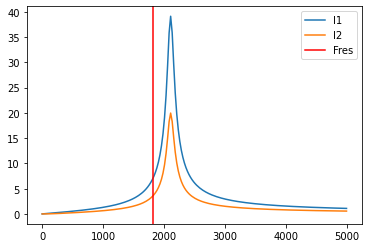

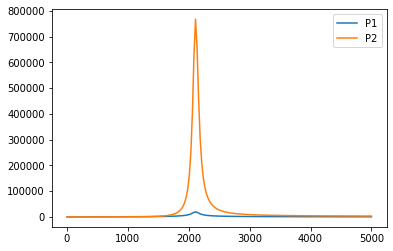

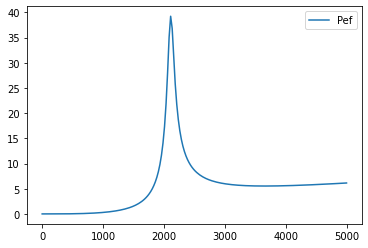

In [3]:
# Natural ressonance frequency:
n = 200
# 
lista_k = np.linspace(0, 1, n)
lista_w = np.linspace(1, 5000, n)

lista_v2 = []
lista_i1 = []
lista_i2 = []
lista_P1 = []
lista_P2 = []
lista_Ef = []

# r1=0.5
# r2=0.5
# l1=300e-3
# l2=300e-3
# f=60
k=0.5

#for k in lista_k:

for w in lista_w:
    # 
    V = 1e3 # V
    # 
    L = 300e-3
    C = 1e-6
    R = 0.5
    # Phasorial Representation of all components:
    XR1 = Z_R(R)     # Ohm
    XR2 = Z_R(R)     # Ohm
    XL1 = Z_L(w, L)  # Ohm
    XL2 = Z_L(w, L)  # Ohm
    XC1 = Z_C(w, C)  # Ohm
    XC2 = Z_C(w, C)  # Ohm
    XRC = Z_R(100)   # Ohm

    # Association between components (Transformer):
    Zp1 = in_series(XC1, XR1)
    Z1 = in_series(XL1, Zp1)

    Zp2 = in_parallel(XC2, XRC)
    Zp3 = in_series(XR2, XL2)
    Z2 = in_series(Zp2, Zp3)


    m = k*sqrt(L*L)
    I1, I2 = transformer(V, w, m, Z1, Z2)
    lista_i1.append(abs(I1))
    lista_i2.append(abs(I2))

    Irc = I2*Z2/XRC

    Pf = abs(power(V, I1))
    Prc = abs(power(XRC*Irc, Irc))
    lista_P1.append( Pf )
    lista_P2.append( Prc )

    lista_Ef.append(Prc/Pf)
    

# Ressonance frequency:
w = 1/sqrt(L*C)

plt.plot(lista_w, lista_i1, label="I1")
plt.plot(lista_w, lista_i2, label="I2")
plt.axvline(w, color='r', linestyle='-', label='Fres')
plt.legend()
plt.show()

plt.plot(lista_w, lista_P1, label="P1")
plt.plot(lista_w, lista_P2, label="P2")
plt.legend()
plt.show()

plt.plot(lista_w, lista_Ef, label="Pef")
plt.legend()
plt.show()



In [4]:
def wireless_power_plant(k, w):
    #
    V = 110 # V
    # 
    L = 300e-3
    C = 1e-6
    R = 0.5
    # Phasorial Representation of all components:
    XR1 = Z_R(R)     # Ohm
    XR2 = Z_R(R)     # Ohm
    XL1 = Z_L(w, L)  # Ohm
    XL2 = Z_L(w, L)  # Ohm
    XC1 = Z_C(w, C)  # Ohm
    XC2 = Z_C(w, C)  # Ohm
    XRC = Z_R(100)     # Ohm
    # Association between components (Transformer's left side):
    Zp1 = in_series(XC1, XR1)
    Z1 = in_series(XL1, Zp1)
    # Association between components (Transformer's right side):
    Zp2 = in_parallel(XC2, XRC)
    Zp3 = in_series(XR2, XL2)
    Z2 = in_series(Zp2, Zp3)

    # Mutual 
    m = k*sqrt(L*L)
    I1, I2 = transformer(V, w, m, Z1, Z2)

    Irc = I2*Z2/XRC

    Pf = abs(power(V, I1))
    Prc = abs(power(XRC*Irc, Irc))

    G = Prc/Pf
    return G



# n = 200
# # 
#     lista_k = np.linspace(0.1, 1, n)
#     lista_w = np.linspace(1, 5000, n)
# #G = np.zeros(n, n)

# k, w = np.meshgrid(lista_k, lista_w)
# G = wireless_power_plant(k, w)

# # Ressonance frequency:
# w = 1/sqrt(L*C)

# # 
# fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
# surf = ax.plot_surface(k, w, G, cmap=cm.plasma, linewidth=0, antialiased=False)



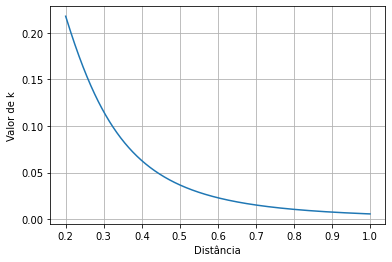

In [5]:
def self_inductance(N, R, mi0):
    # flux = i*pi*e**(-pi) * (4*e**pi + (2**(3/2) - 1)*e**(2**(3/2)) + 1 )*N*R*mi0
    # return flux/i

    # flux = (i*pi*e**(-pi) * (2**(11/2)*e**pi + (32-2**(7/2))*e**(2**(3/2)) + 2**(7/2) )*N*R*mi0)/(2**(13/2))
    return (pi*e**(-pi) * (2**(11/2)*e**pi + (32-2**(7/2))*e**(2**(3/2)) + 2**(7/2) )*N*R*mi0)/(2**(13/2))

def indutanciaMutua(N,R,mi0,d):
    # flux=(i1*pi*N*R**2*d*(sqrt(d**2+R**2)-d)*mi0)/((d**2+R**2)**(3/2))
    # return flux/i1
    return (pi*N*R**2*d*(sqrt(d**2+R**2)-d)*mi0)/((d**2+R**2)**(3/2))

def calcula_k(M,L1,L2):
    return M/sqrt(L1*L2)

def distance_to_k(N, R, mi0, d):
    m = indutanciaMutua(N,R,mi0,d)
    L1 = self_inductance(N,R,mi0)
    L2 = self_inductance(N,R,mi0)
    k = calcula_k(m,L1,L2)
    return k

R=0.2
N=200
mi0=4*pi*10e-7

lista_d = np.linspace(R,1,1000)
lista_k = [ distance_to_k(N, R, mi0, d) for d in lista_d ]

plt.plot(lista_d,lista_k)
plt.xlabel("Distância")
plt.ylabel("Valor de k")
plt.grid()
plt.show()


In [6]:
R = 0.2
N = 200
mi0 = 4*pi*10e-7

lista_d = np.linspace(0.8, R, 100)
lista_w = np.linspace(1000, 2500, 100)

lista_k = [ distance_to_k(N, R, mi0, d) for d in lista_d ]

matrix_G = np.zeros( (len(lista_w), len(lista_k)) )

for idx_w in range(len(lista_w)):
    for idx_k in range(len(lista_k)):
        matrix_G[idx_w, idx_k] = wireless_power_plant(lista_k[idx_k], lista_w[idx_w])

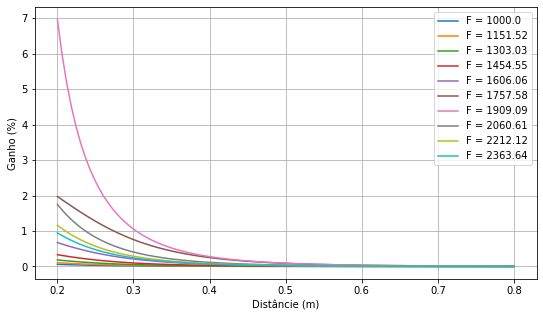

In [21]:
plt.figure(figsize=(9,5))

for i in range(0,100,10):
    plt.plot(lista_d, matrix_G[i,:], label="F = {}".format(round(lista_w[i], 2)))

plt.xlabel("Distâncie (m)")
plt.ylabel("Ganho (%)")
plt.grid()
plt.legend()
plt.show()

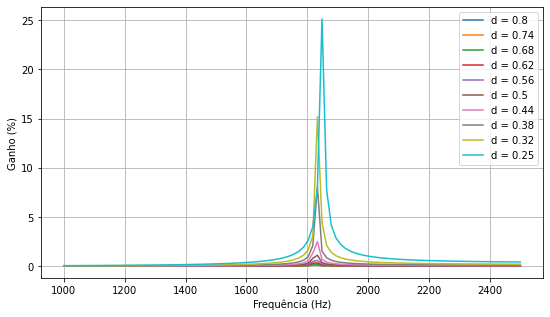

In [16]:
plt.figure(figsize=(9,5))

for i in range(0,100,10):
    plt.plot(lista_w, matrix_G[:,i], label="d = {}".format(round(lista_d[i], 2)))

plt.xlabel("Frequência (Hz)")
plt.ylabel("Ganho (%)")
plt.grid()
plt.legend()
plt.show()


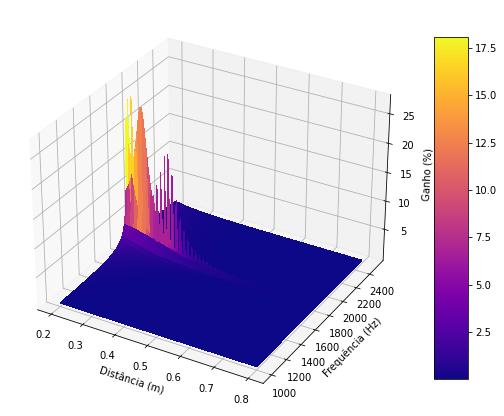

In [11]:
X, Y = np.meshgrid(lista_d, lista_w)
Z = matrix_G

fig = plt.figure(figsize=(9,9))
ax = fig.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.plasma, linewidth=0, antialiased=False)

ax.set_xlabel("Distância (m)")
ax.set_ylabel("Frequência (Hz)")
ax.set_zlabel("Ganho (%)")

fig.colorbar(surf, shrink=0.7, aspect=10)

plt.show()

In [ ]:
def transformer(v1, w, m, z1, z2):
    xm = 1j*w*m
    Z = np.array( [[z1, -xm], [-xm, z2]] )
    V = np.array( [v1, 0] )
    I = np.dot(linalg.inv(Z), V)
    return I[0], I[1]

N=200
R=0.2
resistividade=0.025
lista_r2=[1,5,10,50,100,500,1000]
v1=15/2
XR1 = Z_R(R)     # Ohm
XR2 = Z_R(R)     # Ohm
XL1 = Z_L(w, L)  # Ohm
XL2 = Z_L(w, L)  # Ohm
XC1 = Z_C(w, C)  # Ohm
XC2 = Z_C(w, C)  # Ohm
XRC = Z_R(100)   # Ohm
    # Association between components (Transformer's left side):
Zp1 = in_series(XC1, XR1)
Z1 = in_series(XL1, Zp1)
    # Association between components (Transformer's right side):
Zp2 = in_parallel(XC2, XRC)
Zp3 = in_series(XR2, XL2)
Z2 = in_series(Zp2, Zp3)

    